# Hybrid ViT FER Model with ResNet-50 Backbone on RAF-DB Dataset (Google Colab)

This notebook implements a Hybrid Vision Transformer (ViT) model for Facial Expression Recognition (FER) using the RAF-DB dataset, optimized for Google Colab. The dataset is downloaded directly from [Kaggle](https://www.kaggle.com/datasets/shuvoalok/raf-db-dataset). We use ResNet-50 as the backbone for feature extraction, combined with a ViT architecture.

## Emotions and Labels
- 1: Surprise
- 2: Fear
- 3: Disgust
- 4: Happy
- 5: Sad
- 6: Angry
- 7: Neutral

## Prerequisites
- Upload your Kaggle API token (`kaggle.json`) when prompted.
- Ensure GPU is enabled: `Runtime > Change runtime type > GPU`.

## 1. Setup Environment and Download Dataset
Install required libraries and download the RAF-DB dataset from Kaggle.

In [1]:
# Install dependencies
!pip install transformers seaborn kaggle

In [13]:
# Check transformers version
import transformers
print(f"Transformers version: {transformers.__version__}")

Transformers version: 4.51.3


In [2]:
# Upload kaggle.json for API authentication
from google.colab import files
files.upload()  # Upload kaggle.json when prompted

# Set up Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
# Download RAF-DB dataset
!kaggle datasets download -d shuvoalok/raf-db-dataset -p /content/

# Unzip dataset
!unzip /content/raf-db-dataset.zip -d /content/raf-db-dataset

# Verify dataset structure
!ls /content/raf-db-dataset
!ls /content/raf-db-dataset/DATASET

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: /content/raf-db-dataset/DATASET/train/5/train_00991_aligned.jpg  
  inflating: /content/raf-db-dataset/DATASET/train/5/train_00992_aligned.jpg  
  inflating: /content/raf-db-dataset/DATASET/train/5/train_01002_aligned.jpg  
  inflating: /content/raf-db-dataset/DATASET/train/5/train_01010_aligned.jpg  
  inflating: /content/raf-db-dataset/DATASET/train/5/train_01011_aligned.jpg  
  inflating: /content/raf-db-dataset/DATASET/train/5/train_01013_aligned.jpg  
  inflating: /content/raf-db-dataset/DATASET/train/5/train_01015_aligned.jpg  
  inflating: /content/raf-db-dataset/DATASET/train/5/train_01017_aligned.jpg  
  inflating: /content/raf-db-dataset/DATASET/train/5/train_01039_aligned.jpg  
  inflating: /content/raf-db-dataset/DATASET/train/5/train_01048_aligned.jpg  
  inflating: /content/raf-db-dataset/DATASET/train/5/train_01049_aligned.jpg  
  inflating: /content/raf-db-dataset/DATASET/train/5/train_01053_aligned

## 2. Import Libraries

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from transformers import ViTConfig, ViTModel

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 3. Define Dataset Class

In [14]:
class RAFDBDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.labels_df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        # Adjust labels to be 0-based (0 to 6 instead of 1 to 7)
        self.labels_df['label'] = self.labels_df['label'] - 1

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = self.labels_df.iloc[idx]['image']
        label = self.labels_df.iloc[idx]['label']
        # Construct image path based on label
        label_folder = str(int(label + 1))  # Convert back to 1-7 for folder
        img_path = os.path.join(self.img_dir, label_folder, img_name)

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

## 4. Define Data Transformations

In [15]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## 5. Load Datasets

In [16]:
train_dataset = RAFDBDataset(
    csv_file='/content/raf-db-dataset/train_labels.csv',
    img_dir='/content/raf-db-dataset/DATASET/train',
    transform=train_transform
)

test_dataset = RAFDBDataset(
    csv_file='/content/raf-db-dataset/test_labels.csv',
    img_dir='/content/raf-db-dataset/DATASET/test',
    transform=test_transform
)

In [17]:
# DataLoaders (reduced num_workers for Colab)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

Training samples: 12271
Testing samples: 3068


## 6. Define Hybrid ViT Model

In [18]:
class HybridViT(nn.Module):
    def __init__(self, num_classes=7, embed_dim=768):
        super(HybridViT, self).__init__()

        # ResNet-50 Backbone
        resnet = models.resnet50(pretrained=True)
        self.resnet_features = nn.Sequential(*list(resnet.children())[:-2])  # Remove FC and avgpool

        # Adjust channels and upsample to match ViT input size
        self.conv = nn.Conv2d(2048, 3, kernel_size=1)  # Match ViT's expected 3 channels
        self.upsample = nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False)

        # ViT Configuration
        vit_config = ViTConfig(
            hidden_size=embed_dim,
            num_hidden_layers=12,
            num_attention_heads=12,
            intermediate_size=3072,
            image_size=224,
            patch_size=16,
            num_channels=3  # Standard RGB input
        )
        self.vit = ViTModel(vit_config)

        # Classifier
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # Extract features with ResNet-50
        features = self.resnet_features(x)  # Shape: (batch, 2048, 7, 7)
        features = self.conv(features)  # Shape: (batch, 3, 7, 7)
        features = self.upsample(features)  # Shape: (batch, 3, 224, 224)

        # Pass through ViT
        outputs = self.vit(pixel_values=features)
        pooled_output = outputs.last_hidden_state[:, 0]  # Use [CLS] token

        # Classification
        logits = self.classifier(pooled_output)
        return logits

# Initialize model
model = HybridViT(num_classes=7).to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 7. Define Loss and Optimizer

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

## 8. Training Loop

In [20]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=20):
    train_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Evaluate on test set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracy = 100 * correct / total
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

        # Save checkpoint
        checkpoint_path = f'/content/hybrid_vit_rafdb_epoch_{epoch+1}.pth'
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}")

        scheduler.step()

    return train_losses, test_accuracies

In [21]:
# Train the model
train_losses, test_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler)

Epoch 1/20, Loss: 1.1840, Test Accuracy: 74.61%
Checkpoint saved: /content/hybrid_vit_rafdb_epoch_1.pth
Epoch 2/20, Loss: 0.7635, Test Accuracy: 78.72%
Checkpoint saved: /content/hybrid_vit_rafdb_epoch_2.pth
Epoch 3/20, Loss: 0.6180, Test Accuracy: 77.25%
Checkpoint saved: /content/hybrid_vit_rafdb_epoch_3.pth
Epoch 4/20, Loss: 0.5313, Test Accuracy: 80.74%
Checkpoint saved: /content/hybrid_vit_rafdb_epoch_4.pth
Epoch 5/20, Loss: 0.4677, Test Accuracy: 83.12%
Checkpoint saved: /content/hybrid_vit_rafdb_epoch_5.pth
Epoch 6/20, Loss: 0.3967, Test Accuracy: 80.15%
Checkpoint saved: /content/hybrid_vit_rafdb_epoch_6.pth
Epoch 7/20, Loss: 0.3481, Test Accuracy: 81.75%
Checkpoint saved: /content/hybrid_vit_rafdb_epoch_7.pth
Epoch 8/20, Loss: 0.3019, Test Accuracy: 83.02%
Checkpoint saved: /content/hybrid_vit_rafdb_epoch_8.pth
Epoch 9/20, Loss: 0.2724, Test Accuracy: 81.03%
Checkpoint saved: /content/hybrid_vit_rafdb_epoch_9.pth
Epoch 10/20, Loss: 0.2473, Test Accuracy: 82.33%
Checkpoint save

## 9. Plot Training Metrics

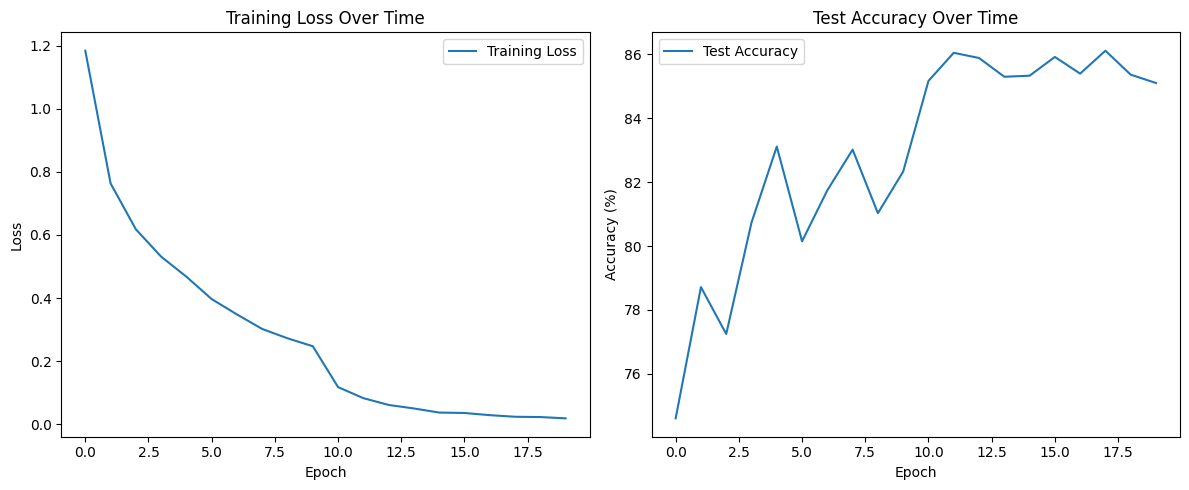

In [22]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Time')
plt.legend()

plt.tight_layout()
plt.show()

## 10. Evaluate Model

In [23]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 8), yticklabels=range(1, 8))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Surprise', 'Fear', 'Disgust', 'Happy', 'Sad', 'Angry', 'Neutral']))

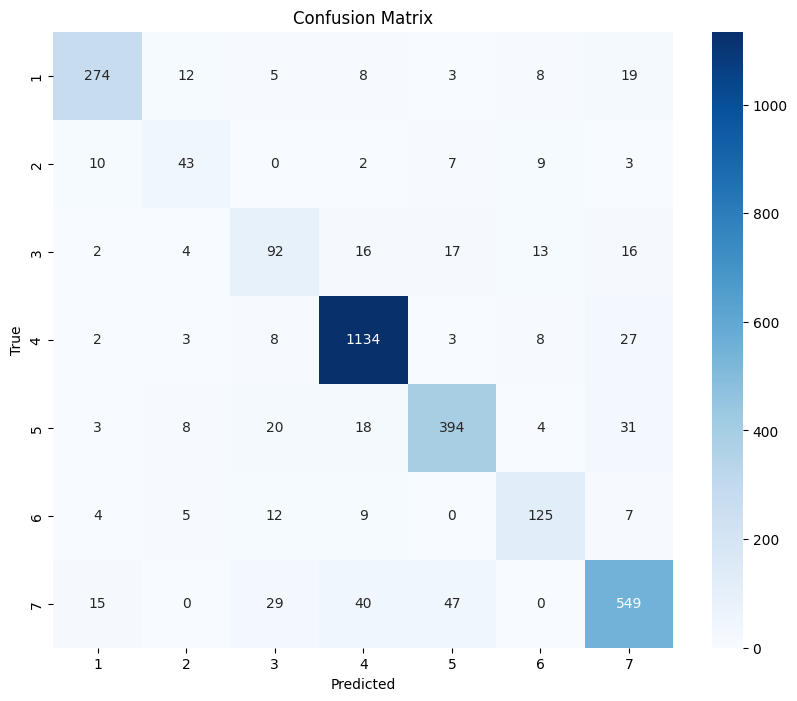


Classification Report:
              precision    recall  f1-score   support

    Surprise       0.88      0.83      0.86       329
        Fear       0.57      0.58      0.58        74
     Disgust       0.55      0.57      0.56       160
       Happy       0.92      0.96      0.94      1185
         Sad       0.84      0.82      0.83       478
       Angry       0.75      0.77      0.76       162
     Neutral       0.84      0.81      0.82       680

    accuracy                           0.85      3068
   macro avg       0.77      0.76      0.76      3068
weighted avg       0.85      0.85      0.85      3068



In [24]:
# Evaluate
evaluate_model(model, test_loader)

## 11. Save Final Model

In [25]:
final_model_path = '/content/Hybrid_ViT_FER_Final.pth'
torch.save(model.state_dict(), final_model_path)
print(f"Final model saved as: {final_model_path}")

Final model saved as: /content/Hybrid_ViT_FER_Final.pth


In [29]:
# Optional: Copy final model to Google Drive for persistence
from google.colab import drive
drive.mount('/content/drive')
!cp /content/Hybrid_ViT_FER_Final.pth /content/drive/MyDrive/Hybrid_ViT_FER.pth
print("Final model copied to Google Drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Final model copied to Google Drive
